In [1]:
import pandas as pd
import numpy as np
import time
from utils import dfwellgr,marker_ssig,extract_signature_Xy,plot_simple
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt

random.seed(42)

### Importing Data

***About the Data***
Parquet Data: columnar type of data
- Training
1. logs.parquet: wellName, DEPTH,GR --> X_data
2. loc.parquet: wellName, Latitude, Longitude -->X_data
3. tops.parquet: wellName, depth of 3 different marker ['MARCEL', 'SYLVAIN', 'CONRAD'], wellName is unique here(no duplication) ---> y

Goal: using GR as input variable and predict the marker of a given depth 

In [2]:
#LOAD DATA
df_tops = pd.read_parquet('Training/tops.parquet', engine='fastparquet')
cols = ['MARCEL', 'SYLVAIN', 'CONRAD']
df_tops = df_tops[cols]
df_tops.dropna(inplace = True)
df_tops[df_tops['CONRAD'] - df_tops['SYLVAIN'] < 0] #Here we can see incorrect data

,MARCEL,SYLVAIN,CONRAD
wellName,,,
512325378.0,6509.0,6794.0,6792.0
512330897.0,6351.0,6617.0,6367.0


In [3]:
df_tops['MARCEL'].min()

5900.0

In [40]:
df_loc = pd.read_parquet('Training/loc.parquet', engine='fastparquet').reset_index()
df_log = pd.read_parquet('Training/logs.parquet', engine='fastparquet') #read parquet as DataFrame
df_log.loc[df_log['GR'] < -1, 'GR' ] = -1 #when GR<-1, change it to -1

df_log = df_loc.merge(df_log, how = 'inner', left_on = 'wellName', right_on = 'wellName') #merge loc info and depth info
df_log.head()

,wellName,Latitude,Longitude,DEPTH,GR
0,512320698.0,48.673353,2.145178,421.0,96.9752
1,512320698.0,48.673353,2.145178,421.5,102.3324
2,512320698.0,48.673353,2.145178,422.0,104.6432
3,512320698.0,48.673353,2.145178,422.5,99.2187
4,512320698.0,48.673353,2.145178,423.0,92.0200


In [41]:
# Load the training_well array from the file which contains the wells with good signature cluster
#shape (3,1)
well_array = np.load('hackaton_training_well_one.npy', allow_pickle=True)

### Visulization(TO BE COMPLETED)

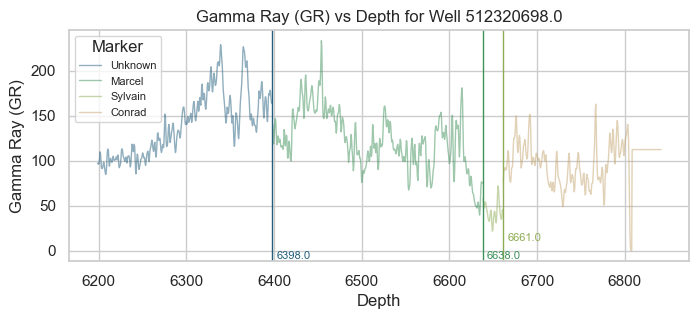

In [6]:
plot_simple(512320698.0,df_log,df_tops)

### Create Dataset For Training

In [7]:
#Create dataset for training with window size 200
input_variable = ['GR']
X, y = extract_signature_Xy(df_log,df_tops,well_array, input_variable, wsize=201 )

Processing wells:   0%|          | 0/534 [00:00<?, ?it/s]

Data Saved Successfully


In [64]:
#Create dataset for training with window size 100
input_variable = ['GR']
X, y = extract_signature_Xy(df_log,df_tops,well_array, input_variable, wsize=101 )

Processing wells:   0%|          | 0/534 [00:00<?, ?it/s]

Data Saved Successfully


In [9]:
#Create dataset for training with window size 50
input_variable = ['GR']
X_50, y_50 = extract_signature_Xy(df_log,df_tops,well_array, input_variable, wsize=51 )

Processing wells:   0%|          | 0/534 [00:00<?, ?it/s]

Data Saved Successfully


In [42]:
#Create dataset for training with window size 50
input_variable = ['GR']
X_50, y_50 = extract_signature_Xy(df_log,df_tops,well_array, input_variable, wsize=21 )

Processing wells:   0%|          | 0/534 [00:00<?, ?it/s]

Data Saved Successfully


### LOAD Testing Data

In [4]:
#Load Testing Data
df_test_log = pd.read_parquet('testdata/logs_50.parquet', engine='fastparquet')
df_test_log.loc[df_test_log['GR'] < -1, 'GR' ] = -1
df_test_log.loc[df_test_log['GR'] > 400, 'GR' ] = 400

df_test_loc = pd.read_parquet('testdata/loc_50.parquet', engine='fastparquet')
df_test_loc = df_test_loc.reset_index()

df_test_log = df_test_loc.merge(df_test_log, how = 'inner', left_on = 'wellName', right_on = 'wellName')

df_test_tops = pd.read_csv('testdata/tops_50.csv')
df_test_tops = df_test_tops.set_index('wellName')
cols = ['MARCEL', 'SYLVAIN', 'CONRAD']
df_test_tops = df_test_tops[cols]

### Pyts ROCKET & Improved Pyts ROCKET

In [5]:
import time
from rocket.new_rocket import Rocket_Faster as ROCKET
from pyts.transformation import ROCKET as pytsROCKET


#Import For Classification 
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

#Import For Testing 
from utils import window, plot_pred_distribution
from utils import get_markers_rocket_order, get_markers_rocket_order_with_constraints

from IPython.display import clear_output
import statistics

In [6]:
# EVALUATION FUNCTIONS
def recall_tops(df_tops_true, df_tops_pred, tolerance = 4):

    if set(df_tops_true.columns) == set(df_tops_pred.columns) :
        concat_df = df_tops_true.copy()
        for col in df_tops_pred.columns:
            concat_df[col+"_pred"] = df_tops_pred[col]
        tp = 0
        p = 0
        mae = 0
        for col in df_tops_true:
            diffname = "{0}_ae".format(col)
            tpname = "{0}_tp".format(col)
            p += concat_df[col].count()
            concat_df[diffname] = concat_df[col]-concat_df[str(col + "_pred")]
            concat_df[diffname] = concat_df[diffname].abs()
            concat_df[tpname] = concat_df[diffname] <= tolerance
            tp += concat_df[tpname].sum()
            mae += concat_df[diffname].sum()
        return tp/p, mae/p, concat_df
    else :
        print("the tops columns are not valid")
    return None,None,None

def find_optimal_tolerance(df_test_tops, df_tops_pred):
    tolerance = 1
    while True:
        recall, mae, _ = recall_tops(df_test_tops, df_tops_pred, tolerance)
        if recall == 1:
            return tolerance
        tolerance += 1

### Wsize = 200

In [21]:
#Load prepared Dataset
X = np.load('prepared_data/X_201.npy')
y = np.load('prepared_data/y_201.npy')

#### FIT & TRANSFORM

In [29]:
# ONLY RUN THIS CELL IF YOU WANT TO USE WSIZE 200
#Split into Train & Validation 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

rocket_faster = ROCKET(n_kernels=10000)
pyts_rocket = pytsROCKET(n_kernels=10000)

## Fit --> reduced time for fitting 
start = time.time()
rocket_faster.fit(X_train_reshaped)
et = time.time() - start
print(f'Fitting time for faster ROCKET: {et}')

start = time.time()
pyts_rocket.fit(X_train_reshaped)
et = time.time() - start
print(f'Fitting time for pyts ROCKET: {et}')

## Transform --> reduced time for transforming 
start = time.time()
X_train_transformed = rocket_faster.transform(X_train_reshaped)
et = time.time() - start
print(f'Transforming time for faster ROCKET: {et}')

start = time.time()
X_train_transformed_pyts = pyts_rocket.transform(X_train_reshaped)
et = time.time() - start
print(f'Transforming time for pyts ROCKET: {et}')

#transform X_test
X_test = X_test.reshape(X_test.shape[0], -1)
X_test_transformed = rocket_faster.transform(X_test)


Fitting time for faster ROCKET: 0.0185239315032959
Fitting time for pyts ROCKET: 0.015083074569702148
Transforming time for faster ROCKET: 6.922010898590088
Transforming time for pyts ROCKET: 37.6589138507843


#### Traditional Classification with the Fast ROCKET (TRAIN & VALIDATION)

In [9]:
#Ridge
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
classifier.fit(X_train_transformed, y_train)

classifier.score(X_test_transformed, y_test)

 #XGBoost classifier
eps = 1e-6

# normalize 'per feature'
f_mean = X_train_transformed.mean(axis=0)
f_std = X_train_transformed.std(axis=0) + eps
X_train_norm = (X_train_transformed - f_mean) / f_std
X_valid_norm = (X_test_transformed - f_mean) / f_std
print(X_train_norm.shape)

classifier_xgb = xgb.XGBClassifier(max_depth=5, n_estimators=100,n_jobs=-1)
classifier_xgb.fit(X_train_norm, y_train)
preds = classifier_xgb.predict(X_valid_norm)

(preds == y_test).mean()

##logistic regression

eps = 1e-6
C = 1e-2
f_mean = X_train_transformed.mean(axis=0)
f_std = X_train_transformed.std(axis=0) + eps  # epsilon to avoid dividing by 0
X_train_tfm2 = (X_train_transformed - f_mean) / f_std
X_valid_tfm2 = (X_test_transformed - f_mean) / f_std
classifier = LogisticRegression(penalty='l2', C=C, n_jobs=-1)
classifier.fit(X_train_tfm2, y_train)
probas = classifier.predict_proba(X_train_tfm2)
train_score = classifier.score(X_train_tfm2, y_train)
val_score = classifier.score(X_valid_tfm2, y_test)
print('{:2} eps: {:.2E}  C: {:.2E}   train_acc: {:.5f}  valid_acc: {:.5f}'.format(1, eps, C, train_score, val_score))

(3367, 20000)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 1 eps: 1.00E-06  C: 1.00E-02   train_acc: 0.99851  valid_acc: 0.99169


#### Testing

In [2]:
# Example Testing with one well before start process prediciton on the entire testing dataset

wsize = 201 #adjust as needed
well = 512325817
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvian', 'Conrad']

#Predict Marker Depth without Constraint 
pred_m, df_wm = get_markers_rocket_order(f_mean, f_std, df_test_log, well, pred_column, wsize, input_variable, rocket_faster, classifier_xgb, classifier, xgb = True)

td  = list(df_test_tops.loc[[well][0]]) 
print(f'Prediction:{pred_m}')
print(f'Real:{td}')
plot_pred_distribution(td, pred_m, df_wm)

NameError: name 'get_markers_rocket_order' is not defined

Error in the training data:<br>
The order of the starting depth of different type of soil(marker) does not follow the logical facts[MARCEL-SYLVAIN-CONARD]<br>
But for the two given wells, the depth of CONRAD is higher than the depth of SYLVAIN, whereas it should be found below SYLVAIN. <br>
***Thus we will apply a Constraint to the prediciton.***

Prediction:[6461, 6601, 6628]
Real:[6460.0, 6592.0, 6620.0]


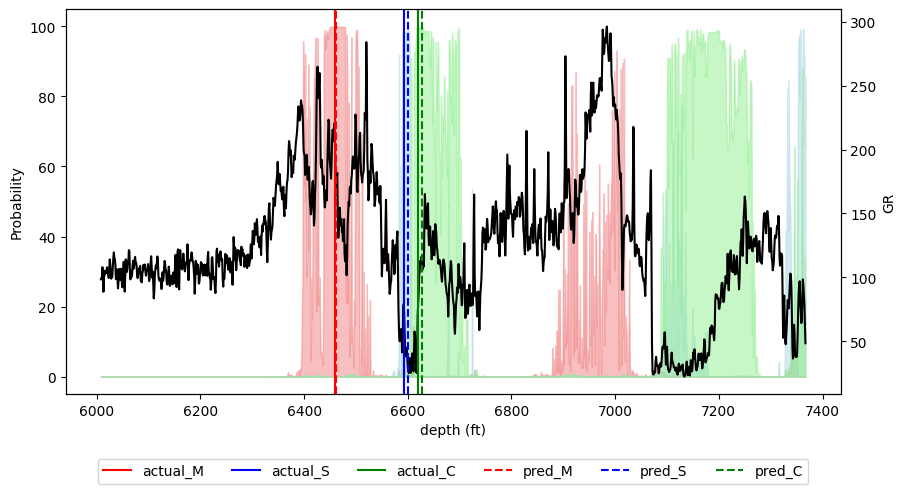

In [17]:
#Predict Marker Depth with Constraint 
pred_m, df_wm = get_markers_rocket_order_with_constraints(f_mean, f_std, df_test_log, well, pred_column, wsize, input_variable, rocket_faster, classifier_xgb, classifier, xgb = True)
print(f'Prediction:{pred_m}')
print(f'Real:{td}')
plot_pred_distribution(td, pred_m, df_wm)

In [12]:
#Predict ALL WITHOUT CONSTRAINTS
#create the predicted_tops for all well, by looping trough the list
start = time.time()
wsize = 201
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvian', 'Conrad']
df_tops_pred = pd.DataFrame(pd.DataFrame(columns = ['wellName','MARCEL', 'SYLVAIN', 'CONRAD']))

for well in df_test_tops.index:
    print(well)
    pred_m, df_wm = get_markers_rocket_order(f_mean, f_std, df_test_log, well, pred_column, wsize, input_variable, rocket_faster, classifier_xgb, classifier,xgb = True)
    print(pred_m)
    row = {'wellName':well, 'MARCEL':pred_m[0], 'SYLVAIN':pred_m[1], 'CONRAD':pred_m[2]}
    row_df = pd.DataFrame([row])
    df_tops_pred = pd.concat([df_tops_pred, row_df], axis = 0, ignore_index = "True")

clear_output()
ext = time.time() - start
print('Total time take',ext)
df_tops_pred['wellName']  = df_tops_pred['wellName'].astype(float)
df_tops_pred = df_tops_pred.sort_values(by = ['wellName']).reset_index().drop(['index'], axis = 1)
df_tops_pred = df_tops_pred.set_index('wellName')
#df_tops_pred.head()

Total time take 626.5661308765411


In [18]:
#call the evaluate function
tr = [20, 15, 10, 5]
for tolerance in tr:
#recall is percentage of positive values that is correclty identified,
# so true positive/ sum of num_all positive
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance)
    print("tolerance {0}, recall {1}, mae {2}".format(tolerance, recall, mae))

optimal_tolerance = find_optimal_tolerance(df_test_tops, df_tops_pred)
print(f"Largest Error MARCEL: {df_result['MARCEL_ae'].max()}")
print(f"Largest Error SYLVAIN: {df_result['SYLVAIN_ae'].max()}")
print(f"Largest Error CONRAD: {df_result['CONRAD_ae'].max()}")
print("Optimal Tolerance :", optimal_tolerance)

tolerance 20, recall 0.9866666666666667, mae 7.76
tolerance 15, recall 0.98, mae 7.76
tolerance 10, recall 0.9666666666666667, mae 7.76
tolerance 5, recall 0.8933333333333333, mae 7.76
Largest Error MARCEL: 25.0
Largest Error SYLVAIN: 770.0
Largest Error CONRAD: 17.0
Optimal Tolerance : 770


In [19]:
#Predict ALL WITHOUT CONSTRAINTS
#create the predicted_tops for all well, by looping trough the list
start = time.time()
wsize = 201
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvian', 'Conrad']
df_tops_pred = pd.DataFrame(pd.DataFrame(columns = ['wellName','MARCEL', 'SYLVAIN', 'CONRAD']))

for well in df_test_tops.index:
    print(well)
    pred_m, df_wm = get_markers_rocket_order_with_constraints(f_mean, f_std, df_test_log, well, pred_column, wsize, input_variable, rocket_faster, classifier_xgb, classifier,xgb = True)
    print(pred_m)
    row = {'wellName':well, 'MARCEL':pred_m[0], 'SYLVAIN':pred_m[1], 'CONRAD':pred_m[2]}
    row_df = pd.DataFrame([row])
    df_tops_pred = pd.concat([df_tops_pred, row_df], axis = 0, ignore_index = "True")

clear_output()
ext = time.time() - start
print('Total time take',ext)
df_tops_pred['wellName']  = df_tops_pred['wellName'].astype(float)
df_tops_pred = df_tops_pred.sort_values(by = ['wellName']).reset_index().drop(['index'], axis = 1)
df_tops_pred = df_tops_pred.set_index('wellName')
#df_tops_pred.head()

Total time take 619.0301849842072


In [20]:
#call the evaluate function
tr = [20, 15, 10, 5]
for tolerance in tr:
#recall is percentage of positive values that is correclty identified,
# so true positive/ sum of num_all positive
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance)
    print("tolerance {0}, recall {1}, mae {2}".format(tolerance, recall, mae))

optimal_tolerance = find_optimal_tolerance(df_test_tops, df_tops_pred)
print(f"Largest Error MARCEL: {df_result['MARCEL_ae'].max()}")
print(f"Largest Error SYLVAIN: {df_result['SYLVAIN_ae'].max()}")
print(f"Largest Error CONRAD: {df_result['CONRAD_ae'].max()}")
print("Optimal Tolerance :", optimal_tolerance)

tolerance 20, recall 0.9933333333333333, mae 2.6866666666666665
tolerance 15, recall 0.9866666666666667, mae 2.6866666666666665
tolerance 10, recall 0.9733333333333334, mae 2.6866666666666665
tolerance 5, recall 0.8933333333333333, mae 2.6866666666666665
Largest Error MARCEL: 25.0
Largest Error SYLVAIN: 13.0
Largest Error CONRAD: 17.0
Optimal Tolerance : 25


### Wsize = 100

In [21]:
#Load prepared Dataset
X = np.load('prepared_data/X_101.npy')
y = np.load('prepared_data/y_101.npy')

#### FIT & TRANSFORM

In [22]:
#Split into Train & Validation 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

rocket_faster = ROCKET()
pyts_rocket = pytsROCKET()

## Fit --> reduced time for fitting 
start = time.time()
rocket_faster.fit(X_train_reshaped)
et = time.time() - start
print(f'Fitting time for faster ROCKET: {et}')

start = time.time()
pyts_rocket.fit(X_train_reshaped)
et = time.time() - start
print(f'Fitting time for pyts ROCKET: {et}')

## Transform --> reduced time for transforming 
start = time.time()
X_train_transformed = rocket_faster.transform(X_train_reshaped)
et = time.time() - start
print(f'Transforming time for faster ROCKET: {et}')

start = time.time()
X_train_transformed_pyts = pyts_rocket.transform(X_train_reshaped)
et = time.time() - start
print(f'Transforming time for pyts ROCKET: {et}')

#transform X_test
X_test = X_test.reshape(X_test.shape[0], -1)
X_test_transformed = rocket_faster.transform(X_test)

Fitting time for faster ROCKET: 0.013289928436279297
Fitting time for pyts ROCKET: 0.007931947708129883
Transforming time for faster ROCKET: 3.778454065322876
Transforming time for pyts ROCKET: 23.94534397125244


#### Fit & Transform for Wsize = 50

In [4]:
# ONLY RUN THIS CELL IF YOU WANT TO USE WSIZE 50
#Split into Train & Validation 
X_train, X_test, y_train, y_test = train_test_split(X_50, y_50, test_size=0.2, random_state=42)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

rocket_faster = ROCKET()
pyts_rocket = pytsROCKET()

## Fit --> reduced time for fitting 
start = time.time()
rocket_faster.fit(X_train_reshaped)
et = time.time() - start
print(f'Fitting time for faster ROCKET: {et}')

start = time.time()
pyts_rocket.fit(X_train_reshaped)
et = time.time() - start
print(f'Fitting time for pyts ROCKET: {et}')

## Transform --> reduced time for transforming 
start = time.time()
X_train_transformed = rocket_faster.transform(X_train_reshaped)
et = time.time() - start
print(f'Transforming time for faster ROCKET: {et}')

start = time.time()
X_train_transformed_pyts = pyts_rocket.transform(X_train_reshaped)
et = time.time() - start
print(f'Transforming time for pyts ROCKET: {et}')

#transform X_test
X_test = X_test.reshape(X_test.shape[0], -1)
X_test_transformed = rocket_faster.transform(X_test)


Fitting time for faster ROCKET: 1.0264039039611816
Fitting time for pyts ROCKET: 1.2617368698120117
Transforming time for faster ROCKET: 3.808624029159546
Transforming time for pyts ROCKET: 14.15451717376709


#### Traditional Classification with the Fast ROCKET (TRAIN & VALIDATION)

In [23]:
#Ridge
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
classifier.fit(X_train_transformed, y_train)

classifier.score(X_test_transformed, y_test)

#XGBoost classifier
eps = 1e-6

# normalize 'per feature'
f_mean = X_train_transformed.mean(axis=0)
f_std = X_train_transformed.std(axis=0) + eps
X_train_norm = (X_train_transformed - f_mean) / f_std
X_valid_norm = (X_test_transformed - f_mean) / f_std
print(X_train_norm.shape)

classifier_xgb = xgb.XGBClassifier(max_depth=5, n_estimators=100,n_jobs=-1)
classifier_xgb.fit(X_train_norm, y_train)
preds = classifier_xgb.predict(X_valid_norm)

print((preds == y_test).mean())

##logistic regression

eps = 1e-6
C = 1e-2
f_mean = X_train_transformed.mean(axis=0)
f_std = X_train_transformed.std(axis=0) + eps  # epsilon to avoid dividing by 0
X_train_tfm2 = (X_train_transformed - f_mean) / f_std
X_valid_tfm2 = (X_test_transformed - f_mean) / f_std
classifier = LogisticRegression(penalty='l2', C=C, n_jobs=-1)
classifier.fit(X_train_tfm2, y_train)
probas = classifier.predict_proba(X_train_tfm2)
train_score = classifier.score(X_train_tfm2, y_train)
val_score = classifier.score(X_valid_tfm2, y_test)
print('{:2} eps: {:.2E}  C: {:.2E}   train_acc: {:.5f}  valid_acc: {:.5f}'.format(1, eps, C, train_score, val_score))

(3369, 20000)
0.9988137603795967


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 1 eps: 1.00E-06  C: 1.00E-02   train_acc: 0.99970  valid_acc: 0.99763


#### Testing

In [25]:
#Predict ALL WITHOUT CONSTRAINTS
#create the predicted_tops for all well, by looping trough the list
start = time.time()
wsize = 101
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvian', 'Conrad']
df_tops_pred = pd.DataFrame(pd.DataFrame(columns = ['wellName','MARCEL', 'SYLVAIN', 'CONRAD']))

for well in df_test_tops.index:
    print(well)
    pred_m, df_wm = get_markers_rocket_order(f_mean, f_std, df_test_log, well, pred_column, wsize, input_variable, rocket_faster, classifier_xgb, classifier,xgb = True)
    print(pred_m)
    row = {'wellName':well, 'MARCEL':pred_m[0], 'SYLVAIN':pred_m[1], 'CONRAD':pred_m[2]}
    row_df = pd.DataFrame([row])
    df_tops_pred = pd.concat([df_tops_pred, row_df], axis = 0, ignore_index = "True")

clear_output()
ext = time.time() - start
print('Total time take',ext)
df_tops_pred['wellName']  = df_tops_pred['wellName'].astype(float)
df_tops_pred = df_tops_pred.sort_values(by = ['wellName']).reset_index().drop(['index'], axis = 1)
df_tops_pred = df_tops_pred.set_index('wellName')
#df_tops_pred.head()

Total time take 450.959801197052


In [26]:
#call the evaluate function
tr = [20, 15, 10, 5]
for tolerance in tr:
#recall is percentage of positive values that is correclty identified,
# so true positive/ sum of num_all positive
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance)
    print("tolerance {0}, recall {1}, mae {2}".format(tolerance, recall, mae))

optimal_tolerance = find_optimal_tolerance(df_test_tops, df_tops_pred)
print(f"Largest Error MARCEL: {df_result['MARCEL_ae'].max()}")
print(f"Largest Error SYLVAIN: {df_result['SYLVAIN_ae'].max()}")
print(f"Largest Error CONRAD: {df_result['CONRAD_ae'].max()}")
print("Optimal Tolerance :", optimal_tolerance)

tolerance 20, recall 0.9733333333333334, mae 3.7133333333333334
tolerance 15, recall 0.9733333333333334, mae 3.7133333333333334
tolerance 10, recall 0.9666666666666667, mae 3.7133333333333334
tolerance 5, recall 0.9333333333333333, mae 3.7133333333333334
Largest Error MARCEL: 123.0
Largest Error SYLVAIN: 24.0
Largest Error CONRAD: 9.0
Optimal Tolerance : 123


In [28]:
#Predict ALL WITHOUT CONSTRAINTS
#create the predicted_tops for all well, by looping trough the list
start = time.time()
wsize = 101
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvian', 'Conrad']
df_tops_pred = pd.DataFrame(pd.DataFrame(columns = ['wellName','MARCEL', 'SYLVAIN', 'CONRAD']))

for well in df_test_tops.index:
    print(well)
    pred_m, df_wm = get_markers_rocket_order_with_constraints(f_mean, f_std, df_test_log, well, pred_column, wsize, input_variable, rocket_faster, classifier_xgb, classifier,xgb = True)
    print(pred_m)
    row = {'wellName':well, 'MARCEL':pred_m[0], 'SYLVAIN':pred_m[1], 'CONRAD':pred_m[2]}
    row_df = pd.DataFrame([row])
    df_tops_pred = pd.concat([df_tops_pred, row_df], axis = 0, ignore_index = "True")

clear_output()
ext = time.time() - start
print('Total time take',ext)
df_tops_pred['wellName']  = df_tops_pred['wellName'].astype(float)
df_tops_pred = df_tops_pred.sort_values(by = ['wellName']).reset_index().drop(['index'], axis = 1)
df_tops_pred = df_tops_pred.set_index('wellName')
#df_tops_pred.head()

Total time take 451.16542172431946


In [29]:
#call the evaluate function
tr = [20, 15, 10, 5]
for tolerance in tr:
#recall is percentage of positive values that is correclty identified,
# so true positive/ sum of num_all positive
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance)
    print("tolerance {0}, recall {1}, mae {2}".format(tolerance, recall, mae))

optimal_tolerance = find_optimal_tolerance(df_test_tops, df_tops_pred)
print(f"Largest Error MARCEL: {df_result['MARCEL_ae'].max()}")
print(f"Largest Error SYLVAIN: {df_result['SYLVAIN_ae'].max()}")
print(f"Largest Error CONRAD: {df_result['CONRAD_ae'].max()}")
print("Optimal Tolerance :", optimal_tolerance)

tolerance 20, recall 0.9733333333333334, mae 3.7133333333333334
tolerance 15, recall 0.9733333333333334, mae 3.7133333333333334
tolerance 10, recall 0.9666666666666667, mae 3.7133333333333334
tolerance 5, recall 0.9333333333333333, mae 3.7133333333333334
Largest Error MARCEL: 123.0
Largest Error SYLVAIN: 24.0
Largest Error CONRAD: 9.0
Optimal Tolerance : 123


### Wsize = 50

In [30]:
#Load prepared Dataset
X = np.load('prepared_data/X_51.npy')
y = np.load('prepared_data/y_51.npy')

#### FIT & TRANSFORM

In [33]:
#Split into Train & Validation 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

rocket_faster = ROCKET()
pyts_rocket = pytsROCKET()

## Fit --> reduced time for fitting 
start = time.time()
rocket_faster.fit(X_train_reshaped)
et = time.time() - start
print(f'Fitting time for faster ROCKET: {et}')

start = time.time()
pyts_rocket.fit(X_train_reshaped)
et = time.time() - start
print(f'Fitting time for pyts ROCKET: {et}')

## Transform --> reduced time for transforming 
start = time.time()
X_train_transformed = rocket_faster.transform(X_train_reshaped)
et = time.time() - start
print(f'Transforming time for faster ROCKET: {et}')

start = time.time()
X_train_transformed_pyts = pyts_rocket.transform(X_train_reshaped)
et = time.time() - start
print(f'Transforming time for pyts ROCKET: {et}')

#transform X_test
X_test = X_test.reshape(X_test.shape[0], -1)
X_test_transformed = rocket_faster.transform(X_test)

Fitting time for faster ROCKET: 0.01300811767578125
Fitting time for pyts ROCKET: 0.006494045257568359
Transforming time for faster ROCKET: 2.794752836227417
Transforming time for pyts ROCKET: 16.462060928344727


#### Traditional Classification with the Fast ROCKET (TRAIN & VALIDATION)

In [34]:
#Ridge
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
classifier.fit(X_train_transformed, y_train)

classifier.score(X_test_transformed, y_test)

#XGBoost classifier
eps = 1e-6

# normalize 'per feature'
f_mean = X_train_transformed.mean(axis=0)
f_std = X_train_transformed.std(axis=0) + eps
X_train_norm = (X_train_transformed - f_mean) / f_std
X_valid_norm = (X_test_transformed - f_mean) / f_std
print(X_train_norm.shape)

classifier_xgb = xgb.XGBClassifier(max_depth=5, n_estimators=100,n_jobs=-1)
classifier_xgb.fit(X_train_norm, y_train)
preds = classifier_xgb.predict(X_valid_norm)

print((preds == y_test).mean())

##logistic regression

eps = 1e-6
C = 1e-2
f_mean = X_train_transformed.mean(axis=0)
f_std = X_train_transformed.std(axis=0) + eps  # epsilon to avoid dividing by 0
X_train_tfm2 = (X_train_transformed - f_mean) / f_std
X_valid_tfm2 = (X_test_transformed - f_mean) / f_std
classifier = LogisticRegression(penalty='l2', C=C, n_jobs=-1)
classifier.fit(X_train_tfm2, y_train)
probas = classifier.predict_proba(X_train_tfm2)
train_score = classifier.score(X_train_tfm2, y_train)
val_score = classifier.score(X_valid_tfm2, y_test)
print('{:2} eps: {:.2E}  C: {:.2E}   train_acc: {:.5f}  valid_acc: {:.5f}'.format(1, eps, C, train_score, val_score))

(3369, 20000)
0.9893238434163701


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 1 eps: 1.00E-06  C: 1.00E-02   train_acc: 0.99763  valid_acc: 0.99051


#### Testing

In [35]:
#Predict ALL WITHOUT CONSTRAINTS
#create the predicted_tops for all well, by looping trough the list
start = time.time()
wsize = 51
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvian', 'Conrad']
df_tops_pred = pd.DataFrame(pd.DataFrame(columns = ['wellName','MARCEL', 'SYLVAIN', 'CONRAD']))

for well in df_test_tops.index:
    print(well)
    pred_m, df_wm = get_markers_rocket_order(f_mean, f_std, df_test_log, well, pred_column, wsize, input_variable, rocket_faster, classifier_xgb, classifier,xgb = True)
    print(pred_m)
    row = {'wellName':well, 'MARCEL':pred_m[0], 'SYLVAIN':pred_m[1], 'CONRAD':pred_m[2]}
    row_df = pd.DataFrame([row])
    df_tops_pred = pd.concat([df_tops_pred, row_df], axis = 0, ignore_index = "True")

clear_output()
ext = time.time() - start
print('Total time take',ext)
df_tops_pred['wellName']  = df_tops_pred['wellName'].astype(float)
df_tops_pred = df_tops_pred.sort_values(by = ['wellName']).reset_index().drop(['index'], axis = 1)
df_tops_pred = df_tops_pred.set_index('wellName')
#df_tops_pred.head()

Total time take 348.1744656562805


In [36]:
#call the evaluate function
tr = [20, 15, 10, 5]
for tolerance in tr:
#recall is percentage of positive values that is correclty identified,
# so true positive/ sum of num_all positive
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance)
    print("tolerance {0}, recall {1}, mae {2}".format(tolerance, recall, mae))

optimal_tolerance = find_optimal_tolerance(df_test_tops, df_tops_pred)
print(f"Largest Error MARCEL: {df_result['MARCEL_ae'].max()}")
print(f"Largest Error SYLVAIN: {df_result['SYLVAIN_ae'].max()}")
print(f"Largest Error CONRAD: {df_result['CONRAD_ae'].max()}")
print("Optimal Tolerance :", optimal_tolerance)

tolerance 20, recall 0.96, mae 4.8966666666666665
tolerance 15, recall 0.96, mae 4.8966666666666665
tolerance 10, recall 0.9333333333333333, mae 4.8966666666666665
tolerance 5, recall 0.9133333333333333, mae 4.8966666666666665
Largest Error MARCEL: 117.0
Largest Error SYLVAIN: 14.0
Largest Error CONRAD: 10.0
Optimal Tolerance : 117


### Mix_Wsize(200 & 50)

In [23]:
#Load prepared Dataset
X_200 = np.load('prepared_data/X_201.npy')
y_200 = np.load('prepared_data/y_201.npy')

X_50 = np.load('prepared_data/X_51.npy')
y_50 = np.load('prepared_data/y_51.npy')

In [24]:
#Split X_200 y_200 into Train & Validation 
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_200, y_200, test_size=0.2, random_state=42)
X_train_reshaped1 = X_train1.reshape(X_train1.shape[0], -1)

rocket_faster1 = ROCKET()
rocket_faster1.fit(X_train_reshaped1)
X_train_transformed1 = rocket_faster1.transform(X_train_reshaped1)

#Split X_50 y_50 into Train & Validation 
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_50, y_50, test_size=0.2, random_state=42)
X_train_reshaped2 = X_train2.reshape(X_train2.shape[0], -1)

rocket_faster2 = ROCKET()
rocket_faster2.fit(X_train_reshaped2)
X_train_transformed2 = rocket_faster2.transform(X_train_reshaped2)

In [25]:
#Classifier For Wsize200

eps = 1e-6
C = 1e-2
# normalize 'per feature'
f_mean1 = X_train_transformed1.mean(axis=0)
f_std1 = X_train_transformed1.std(axis=0) + eps
X_train_norm1 = (X_train_transformed1 - f_mean1) / f_std1

#XGBoost classifier
classifier_xgb1 = xgb.XGBClassifier(max_depth=5, n_estimators=100,n_jobs=-1)
classifier_xgb1.fit(X_train_norm1, y_train1)

##logistic regression
classifier1 = LogisticRegression(penalty='l2', C=C, n_jobs=-1)
classifier1.fit(X_train_norm1, y_train1)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.01, n_jobs=-1)

In [26]:
#Classifier For Wsize50

# normalize 'per feature'
f_mean2 = X_train_transformed2.mean(axis=0)
f_std2 = X_train_transformed2.std(axis=0) + eps
X_train_norm2 = (X_train_transformed2 - f_mean2) / f_std2

#XGBoost classifier
classifier_xgb2 = xgb.XGBClassifier(max_depth=5, n_estimators=100,n_jobs=-1)
classifier_xgb2.fit(X_train_norm2, y_train2)

##logistic regression
classifier2 = LogisticRegression(penalty='l2', C=C, n_jobs=-1)
classifier2.fit(X_train_norm2, y_train2)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.01, n_jobs=-1)

[6464, 7367, 6624]
[6464, 6595, 6619]
Prediction:[6464, 6595, 6619]
Real:[6460.0, 6592.0, 6620.0]


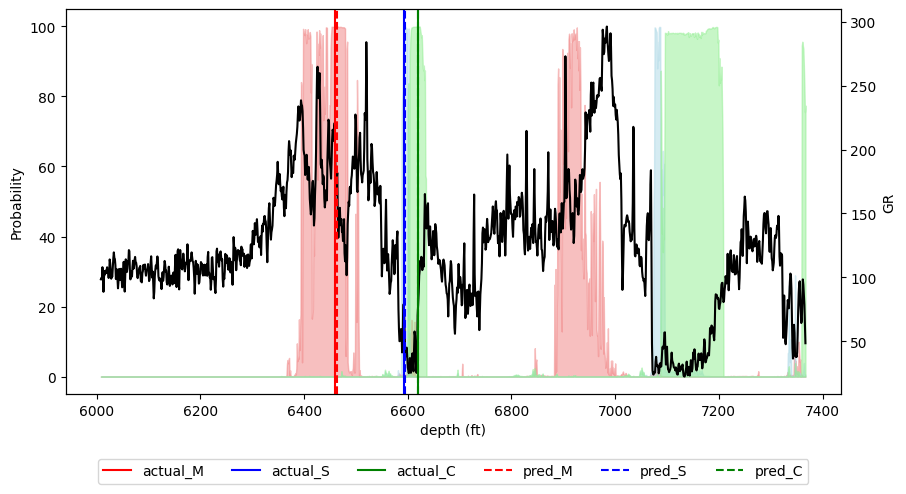

In [27]:
# Example Testing with one well before start process prediciton on the entire testing dataset

wsize1 = 201 
wsize2 = 51
well = 512322535
input_variable=['GR']
pred_column = ['None','Marcel','Sylvian', 'Conrad']

#Predict Marker Depth without Constraint 
pred_m1, df_wm1 = get_markers_rocket_order(f_mean1, f_std1, df_test_log, well, pred_column, wsize1, input_variable, rocket_faster1, classifier_xgb1, classifier1, xgb = True)
pred_m2, df_wm2 = get_markers_rocket_order(f_mean2, f_std2, df_test_log, well, pred_column, wsize2, input_variable, rocket_faster2, classifier_xgb2, classifier2, xgb = True)
print(pred_m1)
print(pred_m2)
pred_m = [pred_m1[0]] + pred_m2[1:3]
df_wm = df_wm1[['GR','Depth','None','Marcel']].merge(df_wm2[['Depth','Sylvian','Conrad']],how='left',on='Depth')
td  = list(df_test_tops.loc[[well][0]]) 
print(f'Prediction:{pred_m}')
print(f'Real:{td}')
plot_pred_distribution(td, pred_m, df_wm)

In [15]:
#Predict ALL WITHOUT CONSTRAINTS
#create the predicted_tops for all well, by looping trough the list
start = time.time()
wsize1 = 201
wsize2 = 51
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvian', 'Conrad']
df_tops_pred = pd.DataFrame(pd.DataFrame(columns = ['wellName','MARCEL', 'SYLVAIN', 'CONRAD']))

for well in df_test_tops.index:
    print(well)
    pred_m1, df_wm1 = get_markers_rocket_order(f_mean1, f_std1, df_test_log, well, pred_column, wsize1, input_variable, rocket_faster1, classifier_xgb1, classifier1, xgb = True)
    pred_m2, df_wm2 = get_markers_rocket_order(f_mean2, f_std2, df_test_log, well, pred_column, wsize2, input_variable, rocket_faster2, classifier_xgb2, classifier2, xgb = True)
    pred_m = [pred_m1[0]] + pred_m2[1:3]
    print(pred_m)
    row = {'wellName':well, 'MARCEL':pred_m[0], 'SYLVAIN':pred_m[1], 'CONRAD':pred_m[2]}
    row_df = pd.DataFrame([row])
    df_tops_pred = pd.concat([df_tops_pred, row_df], axis = 0, ignore_index = "True")

clear_output()
ext = time.time() - start
print('Total time take',ext)
df_tops_pred['wellName']  = df_tops_pred['wellName'].astype(float)
df_tops_pred = df_tops_pred.sort_values(by = ['wellName']).reset_index().drop(['index'], axis = 1)
df_tops_pred = df_tops_pred.set_index('wellName')
#df_tops_pred.head()

Total time take 1031.0859670639038


In [22]:
#call the evaluate function
tr = [20, 15, 10, 5]
for tolerance in tr:
#recall is percentage of positive values that is correclty identified,
# so true positive/ sum of num_all positive
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance)
    print("tolerance {0}, recall {1}, mae {2}".format(tolerance, recall, mae))

optimal_tolerance = find_optimal_tolerance(df_test_tops, df_tops_pred)
print(f"Largest Error MARCEL: {df_result['MARCEL_ae'].max()}")
print(f"Largest Error SYLVAIN: {df_result['SYLVAIN_ae'].max()}")
print(f"Largest Error CONRAD: {df_result['CONRAD_ae'].max()}")
print("Optimal Tolerance :", optimal_tolerance)

tolerance 20, recall 0.9866666666666667, mae 2.6433333333333335
tolerance 15, recall 0.9866666666666667, mae 2.6433333333333335
tolerance 10, recall 0.9666666666666667, mae 2.6433333333333335
tolerance 5, recall 0.9066666666666666, mae 2.6433333333333335
Largest Error MARCEL: 29.0
Largest Error SYLVAIN: 11.0
Largest Error CONRAD: 8.0
Optimal Tolerance : 29
